<a href="https://colab.research.google.com/github/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/blob/main/notebooks/01_ARIMA_SARIMA_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Entrenamiento, Predicción y Evaluación de los modelos Arima y Sarima

#### **Entrenamiento**

In [3]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from datetime import datetime
from io import BytesIO

DATA_GITHUB_URL = 'https://raw.githubusercontent.com/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/refs/heads/main/data/zone1_power_consumption_of_tetouan_city.csv'

# Descargar los datos desde github
response = requests.get(DATA_GITHUB_URL)

# Convertir en un df desde el xlsx de github
df = pd.read_csv(BytesIO(response.content), sep=',')

In [4]:
# Mostrar información del subset
print("Información del dataset:")
print(df.info())

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   datetime               52416 non-null  object 
 1   temperature            52416 non-null  float64
 2   humidity               52416 non-null  float64
 3   wind_speed             52416 non-null  float64
 4   general_diffuse_flows  52416 non-null  float64
 5   zone_1                 52416 non-null  float64
dtypes: float64(5), object(1)
memory usage: 2.4+ MB
None


In [5]:
df_zone1 = df

Extracción de características (como la estacionariedad).

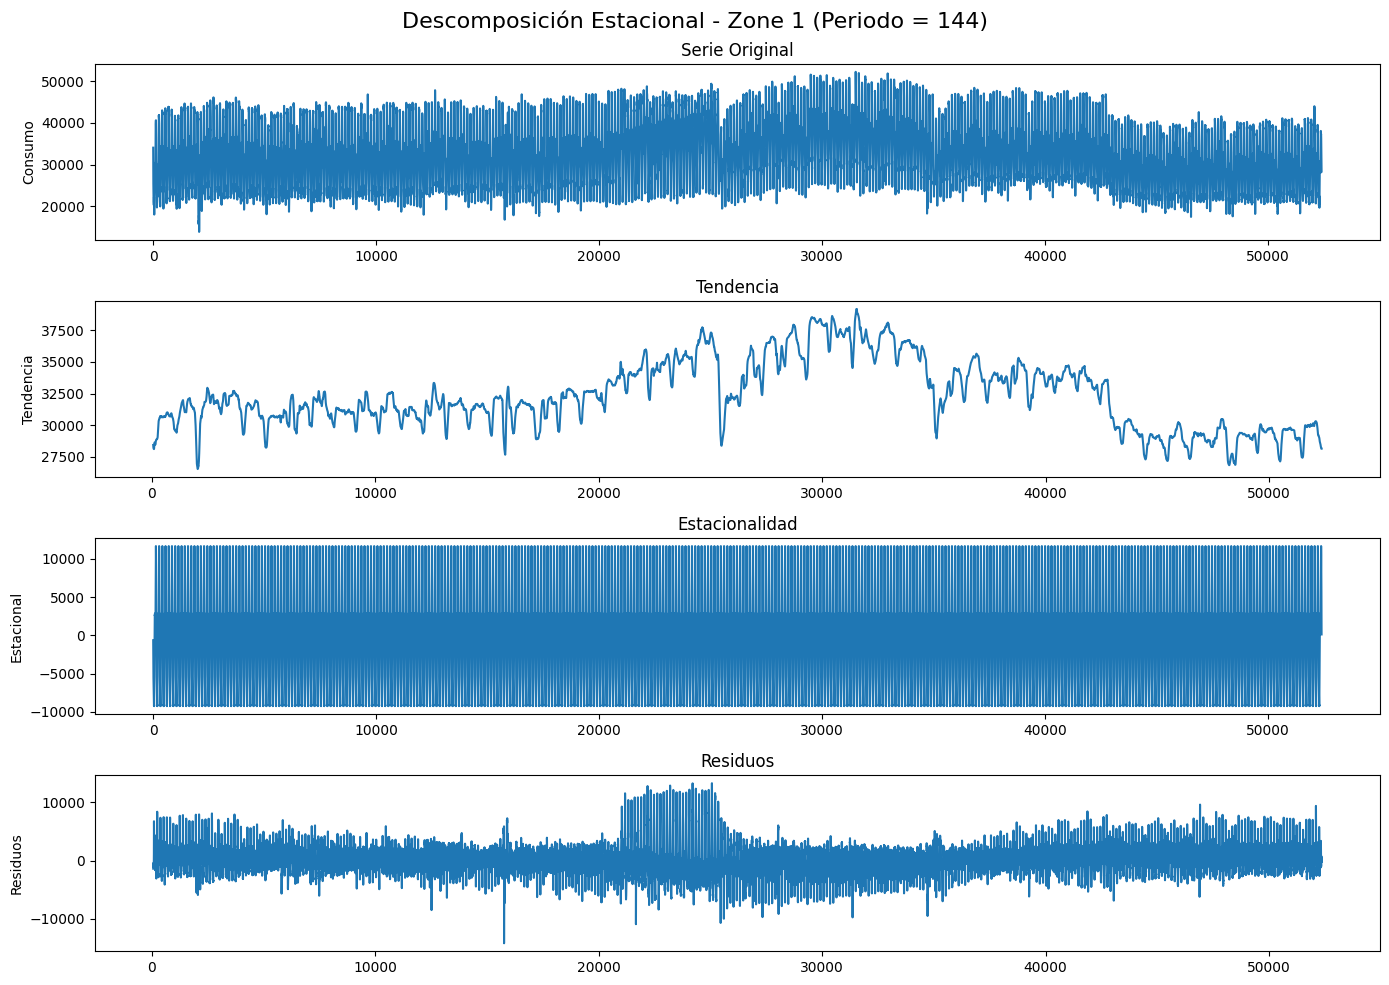

In [6]:
serie = df_zone1['zone_1']
decomposition = seasonal_decompose(serie, model='additive', period=144)

# Visualizar descomposición
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

serie.plot(ax=axes[0], title='Serie Original')
axes[0].set_ylabel('Consumo')

decomposition.trend.plot(ax=axes[1], title='Tendencia')
axes[1].set_ylabel('Tendencia')

decomposition.seasonal.plot(ax=axes[2], title='Estacionalidad')
axes[2].set_ylabel('Estacional')

decomposition.resid.plot(ax=axes[3], title='Residuos')
axes[3].set_ylabel('Residuos')

plt.suptitle('Descomposición Estacional - Zone 1 (Periodo = 144)', fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
print("\n=== Test de Dickey-Fuller Aumentado (Serie Original) ===")
result_adf = adfuller(serie.dropna())
print(f'ADF Statistic: {result_adf[0]:.4f}')
print(f'p-value: {result_adf[1]:.10f}')
print('Valores críticos:')
for key, value in result_adf[4].items():
    print(f'\t{key}: {value:.3f}')


=== Test de Dickey-Fuller Aumentado (Serie Original) ===
ADF Statistic: -32.1213
p-value: 0.0000000000
Valores críticos:
	1%: -3.430
	5%: -2.862
	10%: -2.567


### ANÁLISIS SOBRE LA SELECCIÓN DE HIPERPARÁMETROS

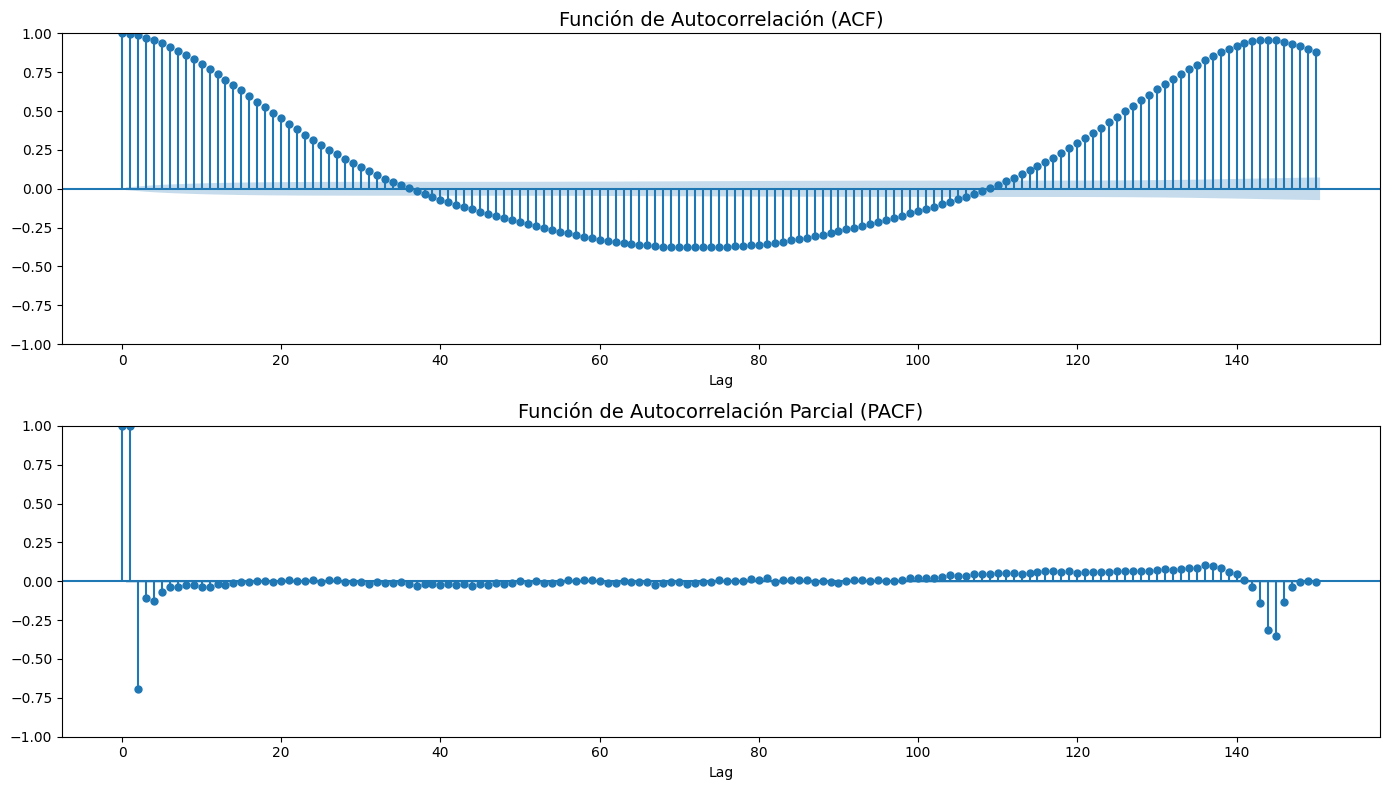

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# ACF
plot_acf(serie.dropna(), lags=150, ax=ax1)
ax1.set_title('Función de Autocorrelación (ACF)', fontsize=14)
ax1.set_xlabel('Lag')

# PACF
plot_pacf(serie.dropna(), lags=150, ax=ax2)
ax2.set_title('Función de Autocorrelación Parcial (PACF)', fontsize=14)
ax2.set_xlabel('Lag')

plt.tight_layout()
plt.show()

Inicialmente, se tiene que el test de Dickey-Fuller arrojó un p-valor = 0.000, por lo que la serie es estacionaria y no se debe diferenciar, d = 0. La componente p de número de términos autorregresivos se puede encontrar a partir de la gráfica de autocorrelación parcial. Se pueden ver picos más significativos en el lag 1 y 2, seguido de un corte abrupto. Esto indica un p = 1 o 2. La ACF no presenta un corte abrupto sino un decaimiento oscilatorio que cruza rápidamente las bandas de confianza, sugiriendo que q=0, aunque podría considerarse q=1 para capturar pequeños efectos de media móvil.

---

#### **Predicción**

### MODELO ARIMA

In [9]:
def smape(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
  return np.mean(np.abs(y_true - y_pred) / denominator) * 100

def wape(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

A un paso

In [10]:
# Usar últimos 7 días
n_dias = 7
n_observaciones = n_dias * 24 * 6  # 7 días * 24h * 6 intervalos = 12960 observaciones

In [11]:
# PREDICCIÓN A UN PASO (10 minutos adelante)

# Seleccionar datos recientes
serie_reciente = serie.tail(n_observaciones)
variable_exogena = df_zone1['temperature'].tail(n_observaciones)

# División train/test (80/20)
split_point = int(len(serie_reciente) * 0.8)
train_serie = serie_reciente[:split_point]
test_serie = serie_reciente[split_point:]
train_exog = variable_exogena[:split_point]
test_exog = variable_exogena[split_point:]

print("=== CONFIGURACIÓN PARA PREDICCIÓN A UN PASO (10 minutos) ===")
print(f"Total observaciones: {len(serie_reciente)}")
print(f"Train: {len(train_serie)} observaciones ({len(train_serie)/6:.1f} horas)")
print(f"Test: {len(test_serie)} observaciones ({len(test_serie)/6:.1f} horas)")
print(f"Horizonte de predicción: 1 paso (10 minutos)")


=== CONFIGURACIÓN PARA PREDICCIÓN A UN PASO (10 minutos) ===
Total observaciones: 1008
Train: 806 observaciones (134.3 horas)
Test: 202 observaciones (33.7 horas)
Horizonte de predicción: 1 paso (10 minutos)


In [12]:
import time
start_time = time.time()

p, d, q = 2, 0, 0
print(f"\n=== ENTRENANDO MODELO ARIMA({p},{d},{q}) ===")

modelo_arima = ARIMA(train_serie, order=(p, d, q))
resultado_arima = modelo_arima.fit()

print(f"AIC: {resultado_arima.aic:.2f}")
print(f"BIC: {resultado_arima.bic:.2f}")

train_time_arima = time.time() - start_time
print(f"Tiempo de entrenamiento: {train_time_arima:.2f} segundos")



=== ENTRENANDO MODELO ARIMA(2,0,0) ===
AIC: 11801.44
BIC: 11820.21
Tiempo de entrenamiento: 0.19 segundos


In [13]:
print("\n=== ARIMA - PRONÓSTICO A UN PASO (One-step ahead) ===")

# get_prediction = usa valores reales para cada paso
pred_arima_one_step = resultado_arima.get_prediction(
    start=test_serie.index[0],
    end=test_serie.index[-1],
    dynamic=False
)

pred_arima_one_step_mean = pred_arima_one_step.predicted_mean

# Evaluamos sobre todo el test
smape_arima_1step = smape(test_serie, pred_arima_one_step_mean)
wape_arima_1step  = wape(test_serie, pred_arima_one_step_mean)

print(f"sMAPE: {smape_arima_1step:.2f}%")
print(f"WAPE : {wape_arima_1step:.2f}%")


=== ARIMA - PRONÓSTICO A UN PASO (One-step ahead) ===
sMAPE: 17.26%
WAPE : 16.82%


A múltiples pasos

In [14]:
print("\n=== ARIMA - PRONÓSTICO MULTI-STEP ===")

n_pasos_futuro = 18   # 3 horas adelante
pred_arima_multi = resultado_arima.get_forecast(steps=n_pasos_futuro)

pred_arima_multi_mean = pred_arima_multi.predicted_mean
pred_arima_multi_mean.index = test_serie.index[:n_pasos_futuro]

smape_arima_multi = smape(test_serie.iloc[:n_pasos_futuro], pred_arima_multi_mean)
wape_arima_multi  = wape(test_serie.iloc[:n_pasos_futuro], pred_arima_multi_mean)

print(f"sMAPE (3h): {smape_arima_multi:.2f}%")
print(f"WAPE  (3h): {wape_arima_multi:.2f}%")


=== ARIMA - PRONÓSTICO MULTI-STEP ===
sMAPE (3h): 1.09%
WAPE  (3h): 1.09%


---

### MODELO SARIMAX


La serie temporal presenta una estacionalidad diaria extremadamente marcada, evidenciada por el comportamiento casi sinusoidal de la ACF con un pico dominante cerca del lag 144 (equivalente a 24 horas con mediciones cada 10 minutos), sugiriendo la presencia de una raíz unitaria estacional que requiere diferenciación estacional (D=1). La PACF revela un spike significativo en los lags iniciales y múltiples picos negativos alrededor del lag 144, patrón característico que indica que, tras aplicar la diferenciación estacional, un término de media móvil estacional captura eficientemente la dependencia temporal, siendo Q=1 la mejor elección. Considerando que el modelo base ya incorpora order=(2,0,0), la configuración estacional óptima sería seasonal_order=(0,1,1,144) como punto de partida, dado que es la parametrización más habitual cuando la ACF estacional domina el comportamiento de la serie.

In [14]:
# Parámetros SARIMAX con estacionalidad diaria
order = (2, 0, 0)
seasonal_order = (0, 1, 1, 144)  # 144 = 24 horas * 6 intervalos

In [15]:
print(f"\n=== MODELO SARIMAX  ===")

start_time = time.time()
try:
    modelo_sarimax = SARIMAX(
        train_serie,
        exog=train_exog,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    resultado_sarimax = modelo_sarimax.fit(disp=False)

    train_time_sarimax = time.time() - start_time
    print(f"Tiempo de entrenamiento: {train_time_sarimax:.2f} segundos")

except Exception as e:
    print(f"Error en el entrenamiento SARIMAX: {e}")



=== MODELO SARIMAX  ===
Tiempo de entrenamiento: 922.06 segundos


In [16]:
print("\n=== SARIMAX - PRONÓSTICO A UN PASO (One-step ahead) ===")

pred_sarimax_one_step = resultado_sarimax.get_prediction(
    start=test_serie.index[0],
    end=test_serie.index[-1],
    exog=test_exog,
    dynamic=False
)

pred_sarimax_one_step_mean = pred_sarimax_one_step.predicted_mean

smape_sarimax_1step = smape(test_serie, pred_sarimax_one_step_mean)
wape_sarimax_1step  = wape(test_serie, pred_sarimax_one_step_mean)

print(f"sMAPE: {smape_sarimax_1step:.2f}%")
print(f"WAPE : {wape_sarimax_1step:.2f}%")



=== SARIMAX - PREDICCIÓN A 1 PASO ===
sMAPE: 0.39%
WAPE : 0.39%


In [17]:
print("\n=== SARIMAX - PRONÓSTICO MULTI-STEP (3h adelante) ===")

pred_sarimax_multi = resultado_sarimax.get_forecast(
    steps=n_pasos_futuro,
    exog=test_exog.iloc[:n_pasos_futuro]
)

pred_sarimax_multi_mean = pred_sarimax_multi.predicted_mean
pred_sarimax_multi_mean.index = test_serie.index[:n_pasos_futuro]

smape_sarimax_multi = smape(test_serie.iloc[:n_pasos_futuro], pred_sarimax_multi_mean)
wape_sarimax_multi  = wape(test_serie.iloc[:n_pasos_futuro], pred_sarimax_multi_mean)

print(f"sMAPE (3h): {smape_sarimax_multi:.2f}%")
print(f"WAPE  (3h): {wape_sarimax_multi:.2f}%")


=== SARIMAX - PREDICCIÓN MULTI-STEP (3h adelante) ===
sMAPE: 1.41%
WAPE : 1.44%


#### **Analisis de resultados**

### PRONÓSTICO A UN PASO MODELOS ARIMA Y SARIMAX

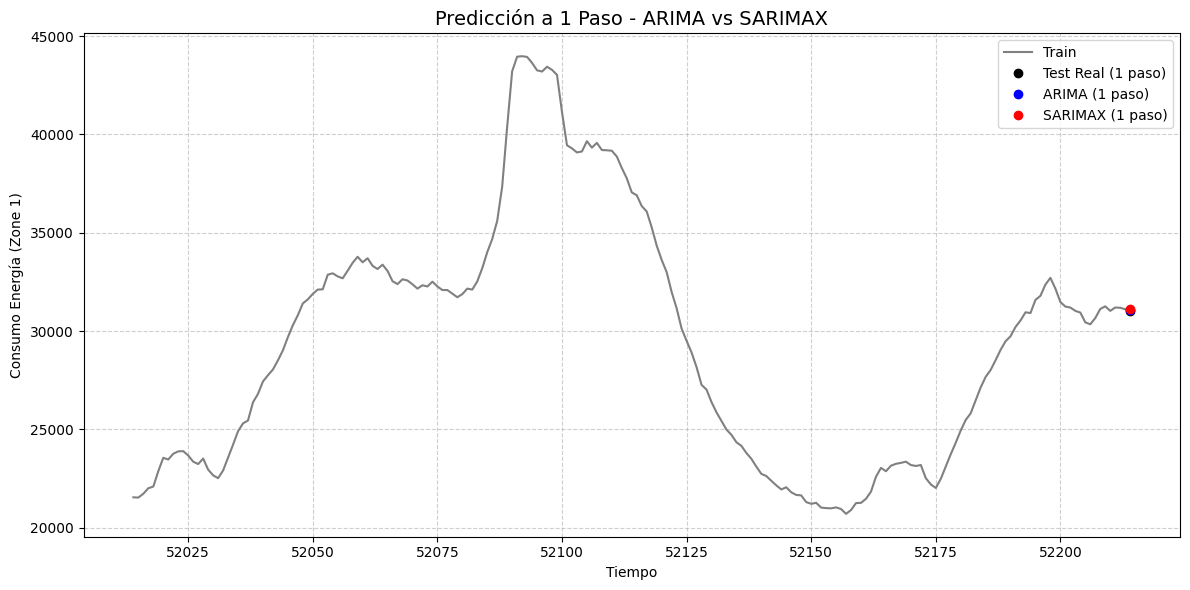

In [19]:
plt.figure(figsize=(12,6))

# Últimos puntos del train (para contexto)
plt.plot(train_serie.index[-200:], train_serie.values[-200:], label="Train", color="gray")

# Primer punto real del test
plt.plot(test_serie.index[0], test_serie.iloc[0], 'o', color="black", label="Test Real (1 paso)")

# Predicción ARIMA (1 paso)
if pred_arima_1 is not None:
    plt.plot(pred_arima_1.index, pred_arima_1.values, 'o', color="blue", label="ARIMA (1 paso)")

# Predicción SARIMAX (1 paso)
if pred_sarimax_1 is not None:
    plt.plot(pred_sarimax_1.index, pred_sarimax_1.values, 'o', color="red", label="SARIMAX (1 paso)")

plt.title("Predicción a 1 Paso - ARIMA vs SARIMAX", fontsize=14)
plt.xlabel("Tiempo")
plt.ylabel("Consumo Energía (Zone 1)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

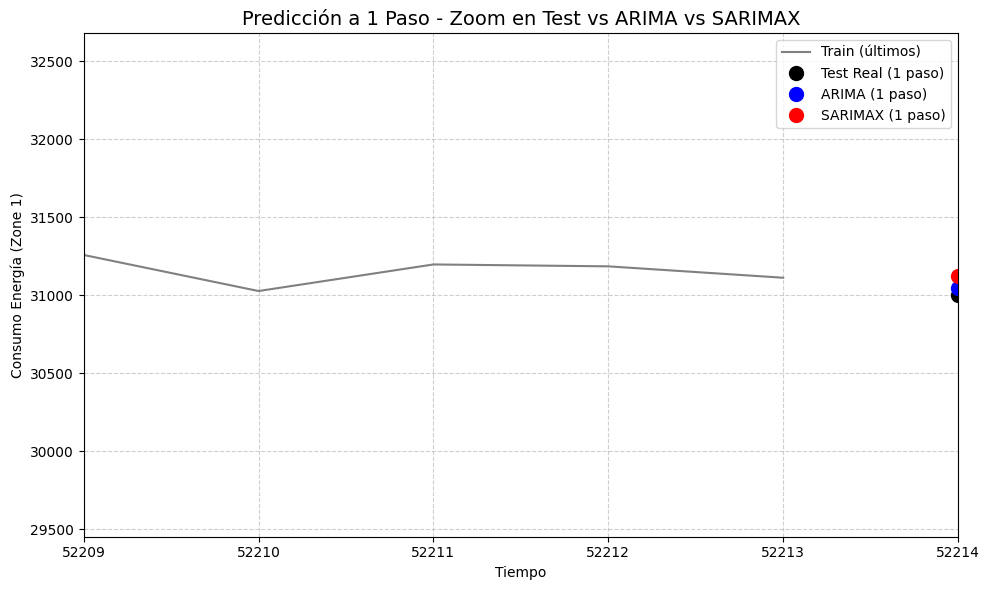

In [21]:
plt.figure(figsize=(10,6))

# Últimos puntos del train para dar contexto (ej. últimos 30 observaciones)
plt.plot(train_serie.index[-30:], train_serie.values[-30:], label="Train (últimos)", color="gray")

# Plot puntos reales y predicciones
plt.plot(test_serie.index[0], test_serie.iloc[0], 'o', color="black", label="Test Real (1 paso)", markersize=10)
plt.plot(pred_arima_1.index, pred_arima_1.values, 'o', color="blue", label="ARIMA (1 paso)", markersize=10)
plt.plot(pred_sarimax_1.index, pred_sarimax_1.values, 'o', color="red", label="SARIMAX (1 paso)", markersize=10)

# --- ZOOM DINÁMICO ---
# Obtener valores mínimo y máximo entre los puntos para hacer zoom
val_min = min(test_serie.iloc[0], pred_arima_1.iloc[0], pred_sarimax_1.iloc[0])
val_max = max(test_serie.iloc[0], pred_arima_1.iloc[0], pred_sarimax_1.iloc[0])

# Márgenes alrededor para que se vea claro (5% extra arriba/abajo)
plt.ylim(val_min*0.95, val_max*1.05)

# Ajustar eje X para enfocar en ese rango puntual
plt.xlim(train_serie.index[-5], test_serie.index[0])

plt.title("Predicción a 1 Paso - Zoom en Test vs ARIMA vs SARIMAX", fontsize=14)
plt.xlabel("Tiempo")
plt.ylabel("Consumo Energía (Zone 1)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

TODO: análisis de la gráfica

### PRONÓSTICO A MÚLTIPLES PASOS MODELOS ARIMA Y SARIMAX

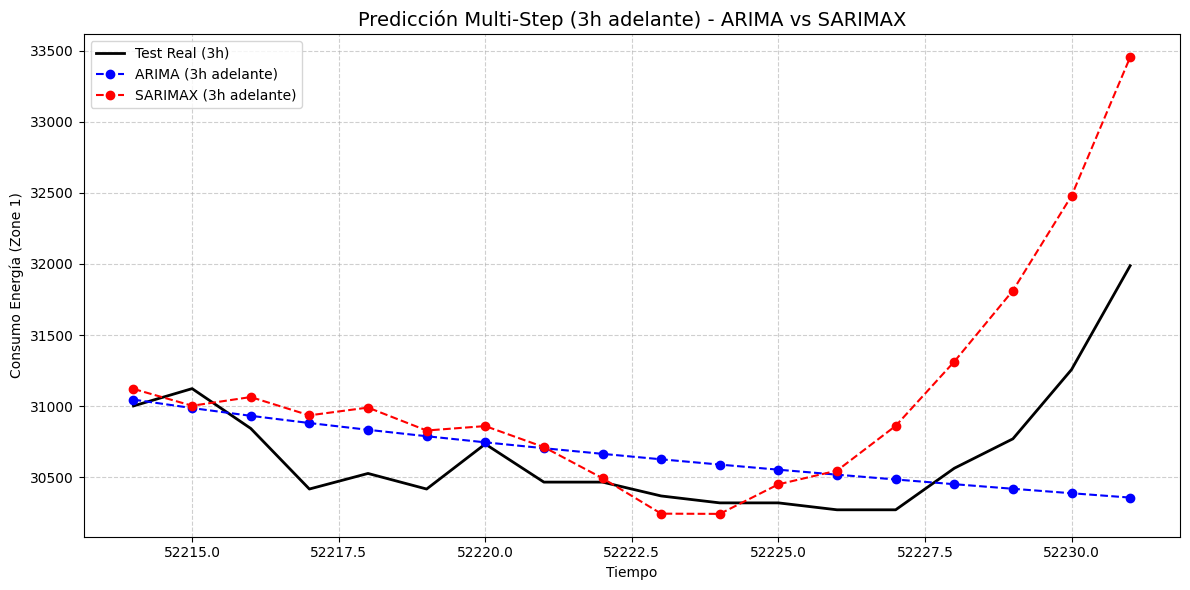

In [20]:
plt.figure(figsize=(12,6))

# Valores reales (últimos 18 puntos test)
plt.plot(test_multi_real.index, test_multi_real.values, label="Test Real (3h)", color="black", linewidth=2)

# Predicción ARIMA multi-step
if pred_arima_multi is not None:
    plt.plot(pred_arima_multi.index, pred_arima_multi.values, '--o', color="blue", label="ARIMA (3h adelante)")

# Predicción SARIMAX multi-step
if pred_sarimax_multi is not None:
    plt.plot(pred_sarimax_multi.index, pred_sarimax_multi.values, '--o', color="red", label="SARIMAX (3h adelante)")

plt.title("Predicción Multi-Step (3h adelante) - ARIMA vs SARIMAX", fontsize=14)
plt.xlabel("Tiempo")
plt.ylabel("Consumo Energía (Zone 1)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

En la predicción multi-step a 3 horas, se observa que al inicio de las predicciones SARIMAX sigue más de cerca el valor real en comparación con ARIMA, logrando captar mejor las fluctuaciones iniciales y reproduciendo con mayor realismo la trayectoria corta, mientras que ARIMA se mantiene excesivamente plano con una ligera tendencia descendente. En la parte media, cuando la serie real se sitúa en un nivel más bajo, SARIMAX coincide con el mínimo de la serie y continúa mostrando mayor ajuste, mientras que ARIMA conserva su tendencia lineal. Sin embargo, en los últimos pasos del horizonte, cuando la serie real comienza a repuntar, ARIMA termina subestimando los valores al no reconocer el cambio de tendencia, mientras que SARIMAX incurre en una sobrestimación notable, generando un crecimiento explosivo no observado en los datos reales. En conjunto, esto indica que SARIMAX ofrece mejor desempeño en horizontes cortos, capturando con mayor fidelidad los patrones inmediatos, aunque con riesgo de inestabilidad en horizontes más largos; en contraste, ARIMA es más estable y predecible en el largo plazo, pero menos sensible a cambios en la serie, lo cual lo hace conservador y plano frente a variaciones dinámicas.

TODO: Análisis de la gráfica

Métricas a evaluar:
1. sMAPE
2. WAPE

In [24]:
import pandas as pd

# =====================================================
# TABLA 1: Pronóstico a 1 paso
# =====================================================
resultados_1paso = []

# ARIMA - un paso
if pred_arima_1 is not None:
    resultados_1paso.append({
        "Modelo": "ARIMA",
        "Horizonte": "1 paso (10 min)",
        "sMAPE (%)": round(smape_arima_1, 2),
        "WAPE (%)": round(wape_arima_1, 2),
        "AIC": round(resultado_arima.aic, 2),
        "BIC": round(resultado_arima.bic, 2)
    })

# SARIMAX - un paso
if pred_sarimax_1 is not None:
    resultados_1paso.append({
        "Modelo": "SARIMAX",
        "Horizonte": "1 paso (10 min)",
        "sMAPE (%)": round(smape_sarimax_1, 2),
        "WAPE (%)": round(wape_sarimax_1, 2),
        "AIC": round(resultado_sarimax.aic, 2),
        "BIC": round(resultado_sarimax.bic, 2)
    })

# Convertimos a DataFrame
df_resultados_1paso = pd.DataFrame(resultados_1paso)
print("\nResultados Pronóstico a 1 Paso:")
print(df_resultados_1paso.to_string(index=False))


# =====================================================
# TABLA 2: Pronóstico multi-step (3 horas = 18 pasos)
# =====================================================
resultados_multi = []

# ARIMA - multi-step
if pred_arima_multi is not None:
    resultados_multi.append({
        "Modelo": "ARIMA",
        "Horizonte": "3h adelante (18 pasos)",
        "sMAPE (%)": round(smape_arima_multi, 2),
        "WAPE (%)": round(wape_arima_multi, 2),
        "AIC": round(resultado_arima.aic, 2),
        "BIC": round(resultado_arima.bic, 2)
    })

# SARIMAX - multi-step
if pred_sarimax_multi is not None:
    resultados_multi.append({
        "Modelo": "SARIMAX",
        "Horizonte": "3h adelante (18 pasos)",
        "sMAPE (%)": round(smape_sarimax_multi, 2),
        "WAPE (%)": round(wape_sarimax_multi, 2),
        "AIC": round(resultado_sarimax.aic, 2),
        "BIC": round(resultado_sarimax.bic, 2)
    })

# Convertimos a DataFrame
df_resultados_multi = pd.DataFrame(resultados_multi)
print("\nResultados Pronóstico Multi-Step (3h adelante):")
print(df_resultados_multi.to_string(index=False))


Resultados Pronóstico a 1 Paso:
 Modelo       Horizonte  sMAPE (%)  WAPE (%)      AIC      BIC
  ARIMA 1 paso (10 min)       0.14      0.14 11801.44 11820.21
SARIMAX 1 paso (10 min)       0.39      0.39  7351.02  7372.26

Resultados Pronóstico Multi-Step (3h adelante):
 Modelo              Horizonte  sMAPE (%)  WAPE (%)      AIC      BIC
  ARIMA 3h adelante (18 pasos)       1.09      1.09 11801.44 11820.21
SARIMAX 3h adelante (18 pasos)       1.41      1.44  7351.02  7372.26


---

TODO: Análisis de las métricas

### REFERENCIAS:

Gianpiero Andrenacci. (2024, September 3). Predicting Time-Series with SARIMAX. Medium; AI Bistrot. https://medium.com/data-bistrot/predicting-time-series-with-sarimax-f805f6608cd2

‌gianpieroandrenacci. (2024, July 13). 📈 COVID-19 New Cases in Italy prediction (ARIMA). Kaggle.com; Kaggle. https://www.kaggle.com/code/gianpieroandrenacci/covid-19-new-cases-in-italy-prediction-arima?source=post_page-----f805f6608cd2---------------------------------------

‌